In [2]:
from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.layers import Input
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.applications.vgg16 import preprocess_input
import numpy as np
import sklearn.datasets

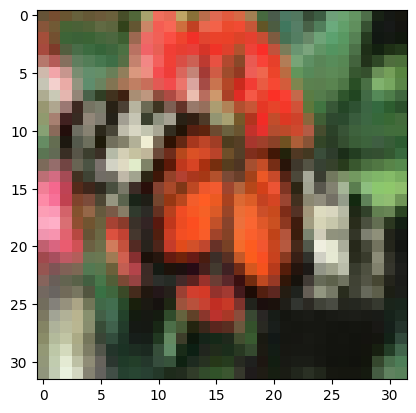

Tamaño del conjunto de entrenamiento: (50000, 32, 32, 3)
Tamaño del conjunto de prueba: (10000, 32, 32, 3)


In [24]:
from keras.datasets import cifar100
import matplotlib.pyplot as plt

(x_train, y_train), (x_test, y_test) = cifar100.load_data(label_mode='fine')

# Mostrar la primera imagen del conjunto de entrenamiento
plt.imshow(x_train[51])
plt.show()

# Imprimir el tamaño de los conjuntos de datos
print('Tamaño del conjunto de entrenamiento:', x_train.shape)
print('Tamaño del conjunto de prueba:', x_test.shape)


In [4]:
x_train[0].shape

(32, 32, 3)

In [5]:
y_train = to_categorical(y_train)
y_train.shape

(50000, 100)

In [6]:
output_count: int = int(y_train[0].shape[0])
output_count

100

In [7]:
#db_olivetti_faces = sklearn.datasets.fetch_olivetti_faces()

In [8]:
# x_train = db_olivetti_faces['images']
# x_train[0].shape

In [9]:
# y_train = db_olivetti_faces['target']
# y_train = to_categorical(y_train)
# y_train.shape

In [10]:
# this could also be the output a different Keras model or layer
input_tensor = Input(shape=x_train[0].shape)

# create the base pre-trained model
# base_model = InceptionV3(
#     input_tensor=input_tensor,
#     weights='imagenet', 
#     include_top=False,
#     )


base_model = VGG16(
    input_tensor=input_tensor,
    weights='imagenet', 
    include_top=False
    )

58889256/58889256 [==============================] - 3s 0us/step


In [20]:
# add a global spatial average pooling layer
x = base_model.output
x = GlobalAveragePooling2D()(x)
# let's add a fully-connected layer
x = Dense(1024, activation='relu')(x)
# and a logistic layer -- let's say we have 200 classes
predictions = Dense(output_count, activation='softmax')(x)

# this is the model we will train
model = Model(inputs=base_model.input, outputs=predictions)

# first: train only the top layers (which were randomly initialized)
# i.e. freeze all convolutional InceptionV3 layers
for layer in base_model.layers:
    layer.trainable = False

# compile the model (should be done *after* setting layers to non-trainable)
model.compile(optimizer='rmsprop', loss='categorical_crossentropy', metrics=['accuracy'])

In [21]:
model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 32, 32, 3)]       0         
                                                                 
 block1_conv1 (Conv2D)       (None, 32, 32, 64)        1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 32, 32, 64)        36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 16, 16, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 16, 16, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 16, 16, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 8, 8, 128)         0   

In [22]:
# train the model on the new data for a few epochs
h = model.fit(x_train, y_train, epochs=10, validation_split = 0.2)

Epoch 1/10
1250/1250 [==============================] - 14s 10ms/step - loss: 4.5759 - accuracy: 0.2161 - val_loss: 3.4750 - val_accuracy: 0.2434
Epoch 2/10
1250/1250 [==============================] - 12s 10ms/step - loss: 3.1071 - accuracy: 0.3063 - val_loss: 3.6207 - val_accuracy: 0.2600
Epoch 3/10
1250/1250 [==============================] - 12s 10ms/step - loss: 2.9326 - accuracy: 0.3518 - val_loss: 3.8032 - val_accuracy: 0.2538
Epoch 4/10
1250/1250 [==============================] - 12s 10ms/step - loss: 2.7867 - accuracy: 0.3798 - val_loss: 4.0974 - val_accuracy: 0.2652
Epoch 5/10
1250/1250 [==============================] - 12s 10ms/step - loss: 2.6633 - accuracy: 0.4095 - val_loss: 4.3285 - val_accuracy: 0.2673
Epoch 6/10
1250/1250 [==============================] - 12s 10ms/step - loss: 2.5471 - accuracy: 0.4417 - val_loss: 4.6442 - val_accuracy: 0.2741
Epoch 7/10
1250/1250 [==============================] - 13s 10ms/step - loss: 2.4127 - accuracy: 0.4682 - val_loss: 4.8179 -

In [23]:
model.save('model1')

In [14]:
# at this point, the top layers are well trained and we can start fine-tuning
# convolutional layers from inception V3. We will freeze the bottom N layers
# and train the remaining top layers.

# let's visualize layer names and layer indices to see how many layers
# we should freeze:
# for i, layer in enumerate(base_model.layers):
#   print(i, layer.name)


0 input_1
1 block1_conv1
2 block1_conv2
3 block1_pool
4 block2_conv1
5 block2_conv2
6 block2_pool
7 block3_conv1
8 block3_conv2
9 block3_conv3
10 block3_pool
11 block4_conv1
12 block4_conv2
13 block4_conv3
14 block4_pool
15 block5_conv1
16 block5_conv2
17 block5_conv3
18 block5_pool


In [15]:
# we chose to train the top 2 inception blocks, i.e. we will freeze
# the first 249 layers and unfreeze the rest:
# for layer in model.layers[:249]:
#    layer.trainable = False
# for layer in model.layers[249:]:
#    layer.trainable = True

In [16]:
# we need to recompile the model for these modifications to take effect
# we use SGD with a low learning rate
# from tensorflow.keras.optimizers import SGD
# model.compile(optimizer=SGD(lr=0.0001, momentum=0.9), loss='categorical_crossentropy')

In [ ]:
# we train our model again (this time fine-tuning the top 2 inception blocks
# alongside the top Dense layers
# model.fit(...)